In [23]:
import numpy as np
import math
import seaborn as sns
from matplotlib import pyplot as plt


The [heatindex](https://de.wikipedia.org/wiki/Hitzeindex) describes the quantitative relationship between perceived temperature and humidity. According to wikipedia, it is applicable for temperatures above 26.7°C and 40 % relative humidity.

$$ \vartheta _{\mathrm {HI} }=c_{1}+c_{2}\vartheta +c_{3}\varphi +c_{4}\vartheta \varphi +c_{5}\vartheta ^{2}+c_{6}\varphi ^{2}+c_{7}\vartheta ^{2}\varphi +c_{8}\vartheta \varphi ^{2}+c_{9}\vartheta ^{2}\varphi ^{2}$$

|Parameter |	ϑ in °C |	ϑ in °F |
|----------|------------|-----------|
c1 | 	−8,784695 |	−42,379 |
c2 |	1,61139411 |	2,04901523 |
c3 |	2,338549 |	10,1433127 |
c4 |	−0,14611605 |	−0,22475541 |
c5 |	−1,2308094 · 10−2 |	−6,83783 · 10−3 |
c6 |	−1,6424828 · 10−2 |	−5,481717 · 10−2 |
c7 |	2,211732 · 10−3 |	1,22874 · 10−3 |
c8 |	7,2546 · 10−4 |	8,5282 · 10−4 |
c9 |	−3,582 · 10−6 |	−1,99 · 10−6 |

[Relative humidity](https://de.wikipedia.org/wiki/Luftfeuchtigkeit#Relative_Luftfeuchtigkeit) (German version of wikipedia is surprisingly better for this article) can be calculated based on the air pressure and the [saturation pressure of water in air](https://en.wikipedia.org/wiki/Vapour_pressure_of_water)

Another expression for perceived temperature is the [Humidex](https://en.wikipedia.org/wiki/Humidex) given by the formula:

$$
H = T_{air} + 0.5555 * (6.11^{5417.753 * (1/273.16 - 1/(273.15+T_{dew}))} - 10)
$$

$H$ ... Humidex \
$T_{air}$ ... Temperature of the air \
$T_{dew}$ ... Dew point of the air

The dew point can be calculated based on the Magnus Formula using the relative humidity of the air. For example formula 10 in the german wiki article about the [dew point](https://de.wikipedia.org/wiki/Taupunkt). Valid between -10 and 60°C.

$$
\tau(\varphi, \vartheta) = K_3 * \frac{\frac{K_2*\vartheta}{K_3 + \vartheta} + ln(\varphi)}{\frac{K_2*K_3}{K_3 + \vartheta}}
$$

In [31]:
class constants:
    gas_constant =  dict(water = 461.51,
                         air_dry = 287.058)  #  (J/(kg*K)
    

def calc_dewpoint(humidity_rel: float, temp: float) -> float:
    """Calculates the dew point of water in air based on the magnus formula

    Based on: https://de.wikipedia.org/wiki/Taupunkt ??

    Parameters
    ------
    humidity_rel: float
        relative humidity between 0 and 1
    temp: float
        temperature in °C
    
    Returns
    ------
    float
        dew point in °C
    """
    k3 = 243.12 # °C
    k2 = 17.62  # °C
    return k3 * (k2*temp/(k3+temp) + np.log(humidity_rel)) / (k2*k3 / (k3 + temp))

def calc_satpressure(temp: float) -> float:
    """Calcuates the saturation pressure of water in air based on the magnus formula
    
    https://www.eas.ualberta.ca/jdwilson/EAS372_13/Vomel_CIRES_satvpformulae.html

    Parameters:
    -----
    temp: float
        temperature in °C

    Returns:
    -----
        saturation pressure of water in Pa
    """
    k3 = 243.5 # °C
    k2 = 17.67  # °C
    return 610.78*np.exp(k2*temp / (k3 + temp))

def calc_ppartial(humidity_rel:float, temp:float)->float:
    """Returns the partial pressure of water in Pa

    https://schweizer-fn.de/lueftung/feuchte/feuchte.php

    Parameters
    -----
    humidity_rel: float
        relative humidity between 0 and 1
    
    temp: float
        temperature in °C
    
    Returns
    ------
    float
        partial pressure of water in Pa
    """
    return humidity_rel * calc_satpressure(temp)


def calc_hum_spec(humidity_rel: float, temp: float, pressure_air: float) -> float:
    """Calculates speficic humidity between 0 and 1

    https://de.wikipedia.org/wiki/Luftfeuchtigkeit#Spezifische_Luftfeuchtigkeit
    https://schweizer-fn.de/lueftung/feuchte/feuchte.php#spezfeuchte

    Parameters
    ------
    temp: float 
        temperature in °C
    
    humidity_rel: float
        relative humidity between 0 and 1
    
    pressure_air: float
        air pressure in Pa

    Returns
    ------
    float
        specific humidity between 0 and 1
    """
    
    ppressure_water = calc_ppartial(humidity_rel, temp)
    rho_water = ppressure_water / (constants.gas_constant["water"]*temp)
    rho_air_dry = (pressure_air - ppressure_water) / (constants.gas_constant["air_dry"]*temp)
    return rho_water / (rho_air_dry + rho_water)

def calc_humidex(temp: float, humidity_rel: float) -> float:
    """Calculates the humidex

    Source and possible test: https://en.wikipedia.org/wiki/Humidex
    Currently visually tested for dew point on x axis, not yet tested if dew point is calculated
    Parameters
    ----.
     temp: float 
        temperature in °C
    
    humidity_rel: float
        relative humidity between 0 and 1

    """
    t_dew = calc_dewpoint(humidity_rel, temp)
    return temp + 0.5555 * (6.11*np.exp(5417.753 * (1/273.16 - 1/(273.15+t_dew))) - 10)

In [32]:
rel_hum = np.arange(30, 90)
dew_point = np.arange(10, 29)

T, D = np.meshgrid(rel_hum = rel_hum, humdew_point)

H = calc_humidex(temp=T, humidity_rel=1, t_dew=D)

TypeError: calc_humidex() got an unexpected keyword argument 't_dew'

<AxesSubplot: >

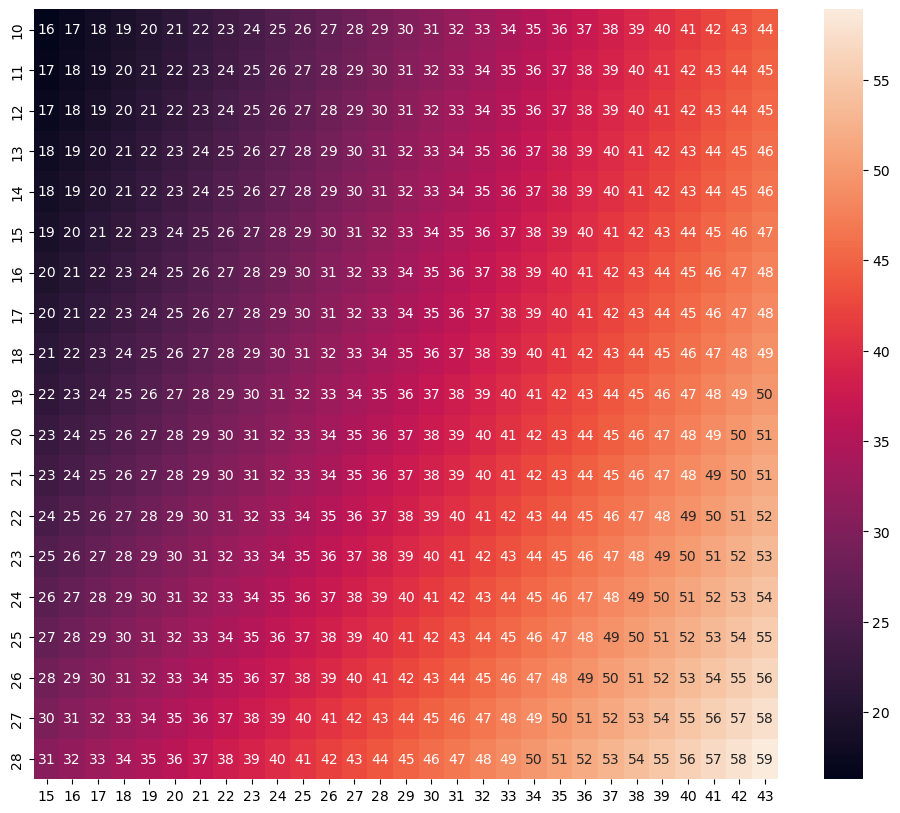

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(12,10))
sns.heatmap(H, xticklabels=temp, yticklabels=dew_point, annot=True, ax=ax)

In [8]:
constants.gas_constant.keys()

NameError: name 'aconstants' is not defined

https://labor.bht-berlin.de/fileadmin/labor/tvt/Umdrucke/2014_Trocknung-Schlempe.pdf